## Coding 3
### Gaurav Shah (gns274)

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
from scipy import integrate, optimize
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from scipy.stats import norm

In [2]:
#Define Variables (1)
a = 0.03
b = 0.002
s = 0.005
sigma_r = 0.02
c = 0.4
kappa_2 = 0.05
rho_infinity = 0.4
T = 10
notional = 50
lambda_A = 0.04
lambda_B = 0.02
recovery_rate = 0.4
spread_B = 0.012

In [3]:
#Define Variables (2)
v = np.sqrt(np.square(1/c) - 1 - 2*((rho_infinity/c) - 1))
sigma_1 = c * sigma_r
sigma_2 = v * sigma_1
rho_x = ((rho_infinity/c) - 1)/v
kappa = np.matrix([[0,0],
                  [0,kappa_2]])
sigma_x = np.matrix([[sigma_1,0],
                  [0,sigma_2]])

$$ y(t) = B(t)\{\int_{0}^{t}q(u)^Tq(u)du\}B(t) $$
$$ temp\_t = q(u)^Tq(u) $$
$$ integrate\_temp\_t = \int_{0}^{t}temp\_t$$

In [4]:
#Function for calculating y(t)
def matrix_calc(t_iter):
    B_t = np.matrix([[1,0],
                    [0,np.exp(-kappa_2*t_iter)]])
    q_t = np.matrix([[sigma_1,rho_x*sigma_1*sigma_2*(np.exp(kappa_2*t_iter))],
                    [rho_x*sigma_1*sigma_2*(np.exp(kappa_2*t_iter)),sigma_2*(np.exp(kappa_2*t_iter))]])
    temp_t = q_t.T * q_t
    integrate_temp_t = np.matrix([[np.square(sigma_1)*t_iter + (np.square(rho_x*sigma_1*sigma_2)*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2), (np.square(sigma_1)*rho_x*sigma_2*(np.exp(kappa_2*t_iter)-1))/(kappa_2) + (np.square(sigma_2)*rho_x*sigma_1*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2)],
                                   [(np.square(sigma_1)*rho_x*sigma_2*(np.exp(kappa_2*t_iter)-1))/(kappa_2) + (np.square(sigma_2)*rho_x*sigma_1*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2), (np.square(rho_x*sigma_1*sigma_2)*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2) + (np.square(sigma_2)*(np.exp(2*kappa_2*t_iter)-1))/(2*kappa_2)]])
    y_t = B_t * integrate_temp_t * B_t
    return y_t

In [5]:
#Calculating all the y(t) to avoid repeating y(t) calculations as y(t) is only dependent on time
delta_t=1/52
matrix_calc_list=[]
for i in range(0,int(T/delta_t)+1):
    t_iter=i*delta_t
    matrix_calc_list.append(matrix_calc(t_iter))

In [6]:
#Function for finding hpar
delta_t = 0.5
def find_hpar(r):
    h = r[0]
    V_0_x_0 = 0
    for T_iter in np.arange(0.5,10.0001,0.5):
        #t = i*delta_t
        V_0_x_0 = V_0_x_0 + notional*((np.exp(s*delta_t)*np.exp(-a*(T_iter-delta_t)-b*((T_iter-delta_t)**2)/2) - np.exp(-a*T_iter-b*(T_iter**2)/2)*(1+delta_t*((h)))))
    return V_0_x_0

In [7]:
#Solve for hpar value 
hpar_value_par = optimize.fsolve(find_hpar,[0])[0]
hpar_value_par = hpar_value_par
print("hpar = ", round(hpar_value_par*100,4),"%")

hpar =  4.4836 %


By solving analytically, hpar differs by 0.2 bps. Hence, we consider hpar = 4.4836% for this assignment neglecting the floating errors caused.

In [8]:
#Function for calculating F(t,x(t),T)
def F(t_iter,x_t,T_iter,y_t,P_0_t):
    G_t_T = np.matrix([[T_iter-t_iter],
               [(1 - np.exp(-kappa_2*(T_iter-t_iter)))/kappa_2]])
    P_0_T = np.exp(-a*T_iter-(b*(T_iter**2)/2))
    P_t_T = (P_0_T/P_0_t) * np.exp(-G_t_T.T * x_t - (G_t_T.T * y_t * G_t_T)/2)
    return P_t_T

In [9]:
#Function for calculating the values of Payer and Receiver legs
#Returns the payer and receciver legs of any swap
def payer_receiver(t_iter,x_t,y_t,P_0_t,delta_T, hpar_value_func):
    sum_payer = 0
    sum_receiver = 0
    for T_iter in np.arange((int(t_iter/0.5)+1)*0.5,10.0001,delta_T):
        if(T_iter==(int(t_iter/0.5)+1)*0.5):
            sum_receiver = sum_receiver + notional*np.exp(s*delta_T)*F(t_iter,x_t,T_iter-delta_T,y_t,P_0_t)
            temp = F(t_iter,x_t,T_iter,y_t,P_0_t)
            sum_payer = sum_payer + notional*temp*(1+(hpar_value_func*delta_T))
        else:
            sum_receiver = sum_receiver + notional*np.exp(s*delta_T)*temp
            temp = F(t_iter,x_t,T_iter,y_t,P_0_t)
            sum_payer = sum_payer + notional*temp*(1+(hpar_value_func*delta_T))
    return (sum_payer,sum_receiver)
#V(t,x) = sum_receiver - sum_payer

Q.1 Expected Exposure of Payer Swap and Receiver Swap

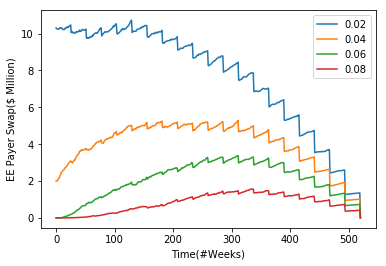

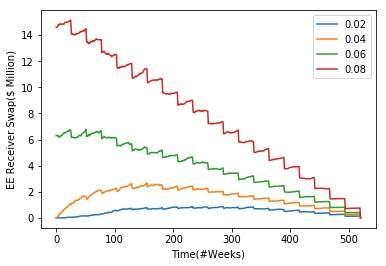

Wall time: 13min 2s


In [10]:
%%time
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.02,0.04,0.06,0.08]
h_total_payer_swap_array=[]
h_total_receiver_swap_array=[]
for hpar_value in hpar_list: # h_par loop for different values of fixed coupon
    total_payer_swap_array = np.zeros(521)
    total_receiver_swap_array = np.zeros(521)
    for j in range(n_paths): #n_path loop for monte carlo
        x_previous = np.matrix([[0],
                               [0]])
        payer_swap_array = np.array([])
        receiver_swap_array = np.array([])
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1): # i loop for creating of weekly sample paths 
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
#             y_t = matrix_calc(t_iter)
            y_t=matrix_calc_list[i]
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            x_previous = x_previous + dx_t
            payer_swap_array = np.append(payer_swap_array,[max(receiver-payer,0)]) # array storing weekly exposure values of payer swap
            receiver_swap_array = np.append(receiver_swap_array,[max(payer-receiver,0)]) # # array storing weekly exposure values of receiver swap
        total_payer_swap_array = total_payer_swap_array + payer_swap_array
        total_receiver_swap_array = total_receiver_swap_array + receiver_swap_array
    total_payer_swap_array = total_payer_swap_array/n_paths # E(E(t)) array for payer swap 
    total_receiver_swap_array = total_receiver_swap_array/n_paths # E(E(t)) array for receiver swap
    h_total_payer_swap_array.append(total_payer_swap_array)
    h_total_receiver_swap_array.append(total_receiver_swap_array)
plt.plot(np.array(h_total_payer_swap_array).T)
plt.xlabel("Time(#Weeks)")
plt.ylabel("EE Payer Swap($ Million)")
plt.gca().legend(('0.02','0.04','0.06','0.08'))
plt.show()
plt.plot(np.array(h_total_receiver_swap_array).T)
plt.xlabel("Time(#Weeks)")
plt.ylabel("EE Receiver Swap($ Million)")
plt.gca().legend(('0.02','0.04','0.06','0.08'))
plt.show()

Q.2 Present Value of Expected Exposure of Payer Swap and Receiver Swap

$$ r(t) = f(0,t) + x_1(t) + x_2(t) $$
$$ discount\_factor = e^{-\int_{0}^{t}r(u)du} $$

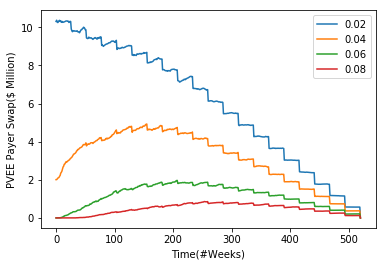

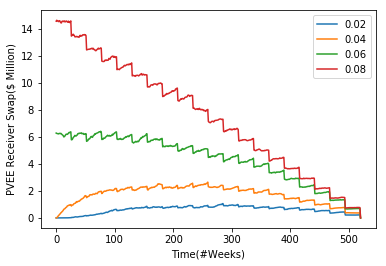

Wall time: 13min 8s


In [11]:
%%time
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.02,0.04,0.06,0.08]
h_total_payer_swap_array=[]
h_total_receiver_swap_array=[]
for hpar_value in hpar_list:
    total_payer_swap_array = np.zeros(521)
    total_receiver_swap_array = np.zeros(521)
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        payer_swap_array = np.array([])
        receiver_swap_array = np.array([])
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
#             y_t = matrix_calc(t_iter)
            y_t=matrix_calc_list[i]
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            discount_factor = np.exp(-(a*t_iter+(b*(t_iter**2)/2) + (x_previous[0,0] + x_previous[1,0])*t_iter)) # calculating discount factors on a weekly scale
            x_previous = x_previous + dx_t
            pvee_payer = max(receiver-payer,0) * discount_factor # array storing discounted exposure values of payer swap
            pvee_receiver = max(payer-receiver,0) * discount_factor # array storing discounted exposure values of receiver swap
            payer_swap_array = np.append(payer_swap_array,[pvee_payer])
            receiver_swap_array= np.append(receiver_swap_array,[pvee_receiver])
        total_payer_swap_array = total_payer_swap_array + payer_swap_array
        total_receiver_swap_array = total_receiver_swap_array + receiver_swap_array
    total_payer_swap_array = total_payer_swap_array/n_paths # PVEE(t) array for payer swap 
    total_receiver_swap_array = total_receiver_swap_array/n_paths # PVEE(t) array for receiver swap 
    h_total_payer_swap_array.append(total_payer_swap_array)
    h_total_receiver_swap_array.append(total_receiver_swap_array)
plt.plot(np.array(h_total_payer_swap_array).T)
plt.xlabel("Time(#Weeks)")
plt.ylabel("PVEE Payer Swap($ Million)")
plt.gca().legend(('0.02','0.04','0.06','0.08'))
plt.show()
plt.plot(np.array(h_total_receiver_swap_array).T)
plt.xlabel("Time(#Weeks)")
plt.ylabel("PVEE Receiver Swap($ Million)")
plt.gca().legend(('0.02','0.04','0.06','0.08'))
plt.show()

Q.3 (i) Expected Exposure of Payer and Receiver Swap with Variation Margin and Margin Period of Risk (2 weeks)

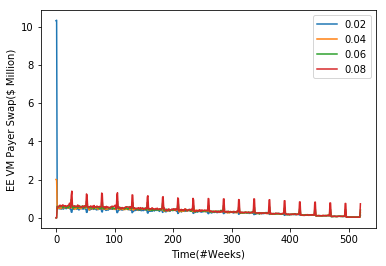

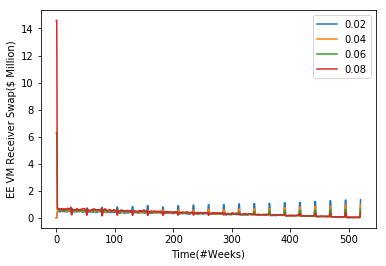

Wall time: 12min 38s


In [12]:
%%time
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.02,0.04,0.06,0.08]
h_total_payer_swap_array=[]
h_total_receiver_swap_array=[]
for hpar_value in hpar_list:
    total_payer_swap_array = np.zeros(521)
    total_receiver_swap_array = np.zeros(521)
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        payer_swap_array = np.array([])
        receiver_swap_array = np.array([])
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
#             y_t = matrix_calc(t_iter)
            y_t=matrix_calc_list[i]
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            x_previous = x_previous + dx_t
            payer_swap_array = np.append(payer_swap_array,[receiver-payer])
            receiver_swap_array= np.append(receiver_swap_array,[payer-receiver])
        payer_swap_array = payer_swap_array - shift(payer_swap_array, 2) # V(t) - V(t-2) for payer swap
        payer_swap_array[payer_swap_array < 0] = 0
        receiver_swap_array = receiver_swap_array - shift(receiver_swap_array, 2) # V(t) - V(t-2) for receiver swap
        receiver_swap_array[receiver_swap_array < 0] = 0
        total_payer_swap_array = total_payer_swap_array + payer_swap_array
        total_receiver_swap_array = total_receiver_swap_array + receiver_swap_array
    total_payer_swap_array = total_payer_swap_array/n_paths # EE(t) with Variation Margin and MPoR is 2 weeks
    total_receiver_swap_array = total_receiver_swap_array/n_paths # EE(t) with Variation Margin and MPoR is 2 weeks
    h_total_payer_swap_array.append(total_payer_swap_array)
    h_total_receiver_swap_array.append(total_receiver_swap_array)
plt.plot(np.array(h_total_payer_swap_array).T)
plt.xlabel("Time(#Weeks)")
plt.ylabel("EE VM Payer Swap($ Million)")
plt.gca().legend(('0.02','0.04','0.06','0.08'))
plt.show()
plt.plot(np.array(h_total_receiver_swap_array).T)
plt.xlabel("Time(#Weeks)")
plt.ylabel("EE VM Receiver Swap($ Million)")
plt.gca().legend(('0.02','0.04','0.06','0.08'))
plt.show()

Q.3 (ii)Present Value of Expected Exposure of Payer and Receiver Swap with Variation Margin and Margin Period of Risk (2 weeks)

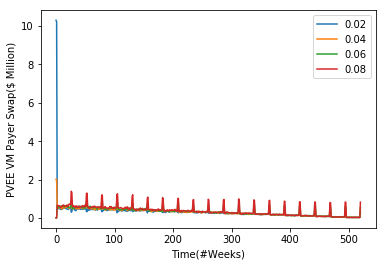

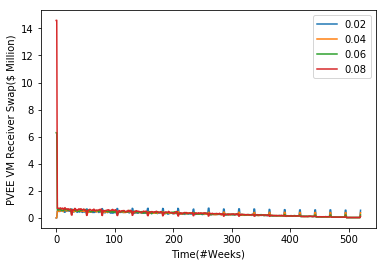

Wall time: 14min 29s


In [13]:
%%time
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.02,0.04,0.06,0.08]
h_total_payer_swap_array=[]
h_total_receiver_swap_array=[]
for hpar_value in hpar_list:
    total_payer_swap_array = np.zeros(521)
    total_receiver_swap_array = np.zeros(521)
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        payer_swap_array = np.array([])
        receiver_swap_array = np.array([])
        discount_factor_array = np.array([])
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
            y_t = matrix_calc(t_iter)
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            discount_factor = np.exp(-(a*t_iter+(b*(t_iter**2)/2) + (x_previous[0,0] + x_previous[1,0])*t_iter))
            x_previous = x_previous + dx_t
            payer_swap_array = np.append(payer_swap_array,[receiver-payer]) # array of V(t) of payer swap
            receiver_swap_array = np.append(receiver_swap_array,[payer-receiver]) # array of V(t) of receiver swap
            discount_factor_array = np.append(discount_factor_array,[discount_factor]) # array of discount factors on a weekly grid
        payer_swap_array = payer_swap_array - shift(payer_swap_array, 2)
        payer_swap_array[payer_swap_array < 0] = 0
        receiver_swap_array = receiver_swap_array - shift(receiver_swap_array, 2)
        receiver_swap_array[receiver_swap_array < 0] = 0
        payer_swap_array = np.multiply(payer_swap_array, discount_factor_array) # V(t) * discount_factor_array(t)
        receiver_swap_array= np.multiply(receiver_swap_array, discount_factor_array)
        total_payer_swap_array = total_payer_swap_array + payer_swap_array
        total_receiver_swap_array = total_receiver_swap_array + receiver_swap_array
    total_payer_swap_array = total_payer_swap_array/n_paths # PVEE(t) with Variation Margin and MPoR is 2 weeks
    total_receiver_swap_array = total_receiver_swap_array/n_paths # PVEE(t) with Variation Margin and MPoR is 2 weeks
    h_total_payer_swap_array.append(total_payer_swap_array)
    h_total_receiver_swap_array.append(total_receiver_swap_array)
plt.plot(np.array(h_total_payer_swap_array).T)
plt.xlabel("Time(#Weeks)")
plt.ylabel("PVEE VM Payer Swap($ Million)")
plt.gca().legend(('0.02','0.04','0.06','0.08'))
plt.show()
plt.plot(np.array(h_total_receiver_swap_array).T)
plt.xlabel("Time(#Weeks)")
plt.ylabel("PVEE VM Receiver Swap($ Million)")
plt.gca().legend(('0.02','0.04','0.06','0.08'))
plt.show()

Q.4 Expected Exposure of Payer Swap with Variation Margin and Initial Margin and Margin Period of Risk (2 weeks)

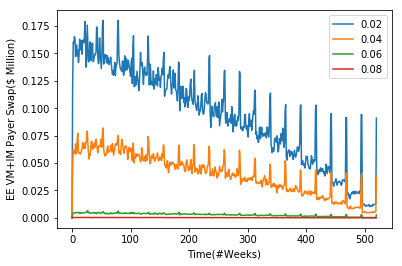

Wall time: 14min 15s


In [14]:
%%time
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
p_list = [0.8,0.9,0.99,0.999]
for p_value in p_list:
    total_payer_swap_array = np.zeros(521)
    im_factor = np.sqrt(2*np.pi)*(norm.pdf(norm.ppf(p_value)) - norm.ppf(p_value)*(1-p_value))
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        payer_swap_array = np.array([])
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
            y_t = matrix_calc(t_iter)
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value_par)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            x_previous = x_previous + dx_t
            payer_swap_array = np.append(payer_swap_array,[receiver-payer]) # array of V(t) of payer swap
        payer_swap_array = payer_swap_array - shift(payer_swap_array, 2) # V(t) - V(t-2) for payer swap
        payer_swap_array[payer_swap_array < 0] = 0 # max(V(t) - V(t-2),0) for payer swap
        #payer_swap_array = np.maximum(payer_swap_array, np.zeros(521))
        total_payer_swap_array = total_payer_swap_array + payer_swap_array
    total_payer_swap_array = total_payer_swap_array/n_paths # EE(t) with Variation Margin and MPoR of 2 weeks
    total_payer_swap_array = total_payer_swap_array * im_factor # EE(t) with Variation Margin and Initial Margin and MPoR of 2 weeks
    plt.plot(total_payer_swap_array)
plt.xlabel("Time(#Weeks)")
plt.ylabel("EE VM+IM Payer Swap($ Million)")
plt.gca().legend(('0.02','0.04','0.06','0.08'))
plt.show()

In [15]:
#Function for Calculating Unilateral CVA
def calculate_CVA(total_payer_swap_array, default_int_counterparty):
    cva = 0
    for i in range(len(total_payer_swap_array)):
        if(i == 0):
            cva = cva + (total_payer_swap_array[i] * (np.exp(-default_int_counterparty*(i/52)) - 1))
        else:
            cva = cva + (total_payer_swap_array[i] * (np.exp(-default_int_counterparty*(i/52)) - np.exp(-default_int_counterparty*(i-1)/52)))
    return cva

In [16]:
#Function for Calculating Bilateral CVA
def calculate_CVA_bi(total_payer_swap_array, default_int_counterparty, default_int_own):
    cva = 0
    for i in range(len(total_payer_swap_array)):
        if(i == 0):
            cva = cva + (total_payer_swap_array[i] * (np.exp(-default_int_counterparty*(i/52)) - 1) * (np.exp(-default_int_own*(i/52))))
        else:
            cva = cva + (total_payer_swap_array[i] * (np.exp(-default_int_counterparty*(i/52)) - np.exp(-default_int_counterparty*(i-1)/52)) * (np.exp(-default_int_own*(i/52))))
    return cva

Q.5 Unilateral Credit Valuation Adjustment (CVA_u) for Payer and Receiver Swap 

In [17]:
#Code for Payer Swap
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.02,0.04,0.06,0.08]
unilateral_cva_array = np.array([])
vm_unilateral_cva_array = np.array([])
for hpar_value in hpar_list:
    total_payer_swap_array = np.zeros(521)
    vm_total_payer_swap_array = np.zeros(521)
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        payer_swap_array = np.array([])
        vm_payer_swap_array = np.array([])
        discount_factor_array = np.array([])
        #np.random.seed(n_paths)
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
            y_t = matrix_calc(t_iter)
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            discount_factor = np.exp(-(a*t_iter+(b*(t_iter**2)/2) + (x_previous[0,0] + x_previous[1,0])*t_iter))
            x_previous = x_previous + dx_t
            pvee = max(receiver-payer,0) * discount_factor # Present Value of Exposure at 't'
            payer_swap_array = np.append(payer_swap_array,[pvee]) # array of PVE(t) for payer swap with no collateral
            
            vm_payer_swap_array = np.append(vm_payer_swap_array,[receiver-payer]) # array of V(t)
            discount_factor_array = np.append(discount_factor_array,[discount_factor])
        
        vm_payer_swap_array = vm_payer_swap_array - shift(vm_payer_swap_array, 2) # array of V(t) - V(t-2)
        vm_payer_swap_array[vm_payer_swap_array < 0] = 0 # array of max(V(t) - V(t-2),0)
        vm_payer_swap_array = np.multiply(vm_payer_swap_array, discount_factor_array) # PV 0f max(V(t) - V(t-2),0) for variation margin
        
        total_payer_swap_array = total_payer_swap_array + payer_swap_array
        vm_total_payer_swap_array = vm_total_payer_swap_array + vm_payer_swap_array
        
    total_payer_swap_array = total_payer_swap_array/n_paths # PVEE(t) with no collateral
    vm_total_payer_swap_array = vm_total_payer_swap_array/n_paths # PVEE(t) with Variation Margin and MPoR of 2 weeks
    
    unilateral_cva = -(1-recovery_rate)*calculate_CVA(total_payer_swap_array, lambda_A) # calculate unilateral CVA with PVEE(t) and Counterparty default intensity
    unilateral_cva_array = np.append(unilateral_cva_array,[unilateral_cva])
    
    vm_unilateral_cva = -(1-recovery_rate)*calculate_CVA(vm_total_payer_swap_array, lambda_A)
    vm_unilateral_cva_array = np.append(vm_unilateral_cva_array,[vm_unilateral_cva])
im_unilateral_cva_array = vm_unilateral_cva_array/117 # PVEE(t) with Variation Margin and Initial Margin and MPoR of 2 weeks
result_unilateral_payer=pd.DataFrame([unilateral_cva_array,vm_unilateral_cva_array,im_unilateral_cva_array],columns=['0.02','0.04','0.06','0.08'],index=['No Collateral','Full VM','Full VM and IM'])

In [18]:
#Code for Receiver Swap
#Same as previous cell except for changes in sign of V(t)
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.02,0.04,0.06,0.08]
unilateral_cva_array = np.array([])
vm_unilateral_cva_array = np.array([])
for hpar_value in hpar_list:
    total_receiver_swap_array = np.zeros(521)
    vm_total_receiver_swap_array = np.zeros(521)
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        receiver_swap_array = np.array([])
        vm_receiver_swap_array = np.array([])
        discount_factor_array = np.array([])
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
            y_t = matrix_calc(t_iter)
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            discount_factor = np.exp(-(a*t_iter+(b*(t_iter**2)/2) + (x_previous[0,0] + x_previous[1,0])*t_iter))
            x_previous = x_previous + dx_t
            pvee = max(payer-receiver,0) * discount_factor
            receiver_swap_array = np.append(receiver_swap_array,[pvee])
            
            vm_receiver_swap_array = np.append(vm_receiver_swap_array,[payer-receiver])
            discount_factor_array = np.append(discount_factor_array,[discount_factor])
        
        vm_receiver_swap_array = vm_receiver_swap_array - shift(vm_receiver_swap_array, 2)
        vm_receiver_swap_array[vm_receiver_swap_array < 0] = 0
        vm_receiver_swap_array = np.multiply(vm_receiver_swap_array, discount_factor_array)
        
        total_receiver_swap_array = total_receiver_swap_array + receiver_swap_array
        vm_total_receiver_swap_array = vm_total_receiver_swap_array + vm_receiver_swap_array
        
    total_receiver_swap_array = total_receiver_swap_array/n_paths
    vm_total_receiver_swap_array = vm_total_receiver_swap_array/n_paths
    
    unilateral_cva = -(1-recovery_rate)*calculate_CVA(total_receiver_swap_array, lambda_A)
    unilateral_cva_array = np.append(unilateral_cva_array,[unilateral_cva])
    
    vm_unilateral_cva = -(1-recovery_rate)*calculate_CVA(vm_total_receiver_swap_array, lambda_A)
    vm_unilateral_cva_array = np.append(vm_unilateral_cva_array,[vm_unilateral_cva])
im_unilateral_cva_array = vm_unilateral_cva_array/117
result_unilateral_receiver=pd.DataFrame([unilateral_cva_array,vm_unilateral_cva_array,im_unilateral_cva_array],columns=['0.02','0.04','0.06','0.08'],index=['No Collateral','Full VM','Full VM and IM'])

In [19]:
print("Results for Unilateral CVA for Payer Swap")
print(result_unilateral_payer)
print("Results for Unilateral CVA for Receiver Swap")
print(result_unilateral_receiver)

Results for Unilateral CVA for Payer Swap
                    0.02      0.04      0.06      0.08
No Collateral   1.234681  0.626075  0.234873  0.084462
Full VM         0.060861  0.062450  0.069207  0.076552
Full VM and IM  0.000520  0.000534  0.000592  0.000654
Results for Unilateral CVA for Receiver Swap
                    0.02      0.04      0.06      0.08
No Collateral   0.136228  0.388271  0.847185  1.537548
Full VM         0.060489  0.062376  0.066411  0.072543
Full VM and IM  0.000517  0.000533  0.000568  0.000620


#### For Payer and Receiver Swap, the CVA decreases with collateral as variation margin and further decreases with introduction of initial margin.
#### For Payer Swaps, the CVA decreases with increase in fixed coupon (h) as the Expected Exposure EE(t) decreases with increase in coupon as evident from results above. In other words, you owe more than you are expected to receive in the payer swap for high values of 'h'. Thus your(bank's) CVA goes down and counterparty's CVA increases, which is evident in the receiver swap results.
#### For Receiver Swaps, we can observe the increase in CVA due to higher expected exposures arising from high values of 'h'. In other words, you are expected to receiver higher coupons than you are expected to pay. Thus your EE increases for higher 'h' (Greater credit risk)

Q.6 Bilateral Credit Valuation Adjustment (CVA_bi) for Payer and Receiver Swap

In [20]:
#Code for Payer Swap
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.02,0.04,0.06,0.08]
bilateral_cva_array = np.array([])
vm_bilateral_cva_array = np.array([])
for hpar_value in hpar_list:
    total_payer_swap_array = np.zeros(521)
    vm_total_payer_swap_array = np.zeros(521)
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        payer_swap_array = np.array([])
        vm_payer_swap_array = np.array([])
        discount_factor_array = np.array([])
        #np.random.seed(n_paths)
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
            y_t = matrix_calc(t_iter)
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            discount_factor = np.exp(-(a*t_iter+(b*(t_iter**2)/2) + (x_previous[0,0] + x_previous[1,0])*t_iter))
            x_previous = x_previous + dx_t
            pvee = max(receiver-payer,0) * discount_factor # Present Value of Exposure at 't'
            payer_swap_array = np.append(payer_swap_array,[pvee]) # array of PVE(t) for payer swap with no collateral
            
            vm_payer_swap_array = np.append(vm_payer_swap_array,[receiver-payer]) # array of V(t)
            discount_factor_array = np.append(discount_factor_array,[discount_factor])
        
        vm_payer_swap_array = vm_payer_swap_array - shift(vm_payer_swap_array, 2) # array of V(t) - V(t-2)
        vm_payer_swap_array[vm_payer_swap_array < 0] = 0 # array of max(V(t) - V(t-2),0)
        vm_payer_swap_array = np.multiply(vm_payer_swap_array, discount_factor_array) # PV 0f max(V(t) - V(t-2),0) for variation margin
        
        total_payer_swap_array = total_payer_swap_array + payer_swap_array
        vm_total_payer_swap_array = vm_total_payer_swap_array + vm_payer_swap_array
        
    total_payer_swap_array = total_payer_swap_array/n_paths # PVEE(t) with no collateral
    vm_total_payer_swap_array = vm_total_payer_swap_array/n_paths # PVEE(t) with Variation Margin and MPoR of 2 weeks
    
    bilateral_cva = -(1-recovery_rate)*calculate_CVA_bi(total_payer_swap_array, lambda_A, lambda_B) # calculate bilateral CVA with PVEE(t) and Counterparty and self default intensity
    bilateral_cva_array = np.append(bilateral_cva_array,[bilateral_cva])
    
    vm_bilateral_cva = -(1-recovery_rate)*calculate_CVA_bi(vm_total_payer_swap_array, lambda_A, lambda_B)
    vm_bilateral_cva_array = np.append(vm_bilateral_cva_array,[vm_bilateral_cva])
im_bilateral_cva_array = vm_bilateral_cva_array/117 # PVEE(t) with Variation Margin and Initial Margin and MPoR of 2 weeks
result_bilateral_payer = pd.DataFrame([bilateral_cva_array,vm_bilateral_cva_array,im_bilateral_cva_array],columns=['0.02','0.04','0.06','0.08'],index=['No Collateral','Full VM','Full VM and IM'])

In [21]:
#Code for Receiver Swap
#Same as previous cell except for changes in sign of V(t)
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.02,0.04,0.06,0.08]
bilateral_cva_array = np.array([])
vm_bilateral_cva_array = np.array([])
for hpar_value in hpar_list:
    total_receiver_swap_array = np.zeros(521)
    vm_total_receiver_swap_array = np.zeros(521)
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        receiver_swap_array = np.array([])
        vm_receiver_swap_array = np.array([])
        discount_factor_array = np.array([])
        #np.random.seed(n_paths)
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
            y_t = matrix_calc(t_iter)
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            discount_factor = np.exp(-(a*t_iter+(b*(t_iter**2)/2) + (x_previous[0,0] + x_previous[1,0])*t_iter))
            x_previous = x_previous + dx_t
            pvee = max(payer-receiver,0) * discount_factor
            receiver_swap_array = np.append(receiver_swap_array,[pvee])
            
            vm_receiver_swap_array = np.append(vm_receiver_swap_array,[payer-receiver])
            discount_factor_array = np.append(discount_factor_array,[discount_factor])
        
        vm_receiver_swap_array = vm_receiver_swap_array - shift(vm_receiver_swap_array, 2)
        vm_receiver_swap_array[vm_receiver_swap_array < 0] = 0
        vm_receiver_swap_array = np.multiply(vm_receiver_swap_array, discount_factor_array)
        
        total_receiver_swap_array = total_receiver_swap_array + receiver_swap_array
        vm_total_receiver_swap_array = vm_total_receiver_swap_array + vm_receiver_swap_array
        
    total_receiver_swap_array = total_receiver_swap_array/n_paths
    vm_total_receiver_swap_array = vm_total_receiver_swap_array/n_paths
    
    bilateral_cva = -(1-recovery_rate)*calculate_CVA_bi(total_receiver_swap_array, lambda_A, lambda_B)
    bilateral_cva_array = np.append(bilateral_cva_array,[bilateral_cva])
    
    vm_bilateral_cva = -(1-recovery_rate)*calculate_CVA_bi(vm_total_receiver_swap_array, lambda_A, lambda_B)
    vm_bilateral_cva_array = np.append(vm_bilateral_cva_array,[vm_bilateral_cva])
im_bilateral_cva_array = vm_bilateral_cva_array/117
result_bilateral_receiver=pd.DataFrame([bilateral_cva_array,vm_bilateral_cva_array,im_bilateral_cva_array],columns=['0.02','0.04','0.06','0.08'],index=['No Collateral','Full VM','Full VM and IM'])

In [22]:
%%time
print("Results for Bilateral CVA for Payer Swap")
print(result_bilateral_payer)
print("Results for Bilateral CVA for Receiver Swap")
print(result_bilateral_receiver)

Results for Bilateral CVA for Payer Swap
                    0.02      0.04      0.06      0.08
No Collateral   1.183184  0.532955  0.210629  0.078561
Full VM         0.056290  0.059905  0.064267  0.071931
Full VM and IM  0.000481  0.000512  0.000549  0.000615
Results for Bilateral CVA for Receiver Swap
                    0.02      0.04      0.06      0.08
No Collateral   0.120727  0.309516  0.832625  1.479589
Full VM         0.056401  0.057335  0.062877  0.069081
Full VM and IM  0.000482  0.000490  0.000537  0.000590
Wall time: 2.99 ms


#### Bilateral CVA < Unilateral CVA for all cases as expected

Q.7 Funding Valuation Adjustment (FVA)

$$ FVA = {\int_{0}^{T_m}S_B(t)*V(t)*e^{-\int_{0}^{t}\lambda_B(u)du}*e^{-\int_{0}^{t}r(u)du}}dt $$

$$ FVA\_Payer = {\sum_{0}^{T_m}spread_B*(receiver-payer)*e^{-\int_{0}^{t}\lambda_B(u)du}*discount\_factor}*delta\_t$$

In [23]:
%%time
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.02,0.04,0.06,0.08]
fva_payer_array = np.array([])
fva_receiver_array = np.array([])
for hpar_value in hpar_list:
    total_payer_swap_array = np.zeros(521)
    total_receiver_swap_array = np.zeros(521)
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        payer_swap_array = np.array([])
        receiver_swap_array = np.array([])
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
            y_t = matrix_calc(t_iter)
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            discount_factor = np.exp(-(a*t_iter+(b*(t_iter**2)/2) + (x_previous[0,0] + x_previous[1,0])*t_iter))
            x_previous = x_previous + dx_t
            fva_payer = (receiver-payer) * discount_factor * np.exp(-lambda_B*t_iter) * spread_B * delta_t # See discretized FVA_Payer formula mentioned above
            fva_receiver = (payer-receiver) * discount_factor * np.exp(-lambda_B*t_iter) * spread_B * delta_t # Same logic as FVA_Payer but change in V(t)
            payer_swap_array = np.append(payer_swap_array,[fva_payer]) # array consisting of fva values for payer swap for 1 path on a discretized time grid. Sum of these values will be FVA for the Payer Swap for that path.
            receiver_swap_array = np.append(receiver_swap_array,[fva_receiver])
#         print(np.sum(payer_swap_array))
        total_payer_swap_array = total_payer_swap_array + payer_swap_array
        total_receiver_swap_array = total_receiver_swap_array + receiver_swap_array
    total_payer_swap_array = total_payer_swap_array/n_paths # Dividing by n_paths for Monte Carlo. Array consisting of average fva values for payer swap for n_paths on a discretized time grid. Sum of these values will be FVA for the Payer Swap for the monte carlo.
    total_receiver_swap_array = total_receiver_swap_array/n_paths
    total_payer_swap_array = np.sum(total_payer_swap_array) # Sum of individual time t FVA values as mentioned above
    total_receiver_swap_array=np.sum(total_receiver_swap_array)
    fva_payer_array = np.append(fva_payer_array,[total_payer_swap_array])
    fva_receiver_array = np.append(fva_receiver_array,[total_receiver_swap_array])
print("Results for FVA for Payer and Receiver Swap:")
result_fva=pd.DataFrame([fva_payer_array,fva_receiver_array],columns=['0.02','0.04','0.06','0.08'],index=['FVA Payer','FVA Receiver'])
print(result_fva)

Results for FVA for Payer and Receiver Swap:
                  0.02      0.04      0.06      0.08
FVA Payer     0.588434  0.114213 -0.328056 -0.863012
FVA Receiver -0.588434 -0.114213  0.328056  0.863012
Wall time: 15min 1s


#### FVA values for Payer Swap are negative because Funding Cost Adjustment is less than Funding Benefit Adjustment in this case. 
#### From a trader's point of view, a payer swap is a synthetic short position as the position would benefit from decrease in bond prices. 
#### Thus in this case B (bank) is short derivative assets, and is therefore in the aggregate receiving funding from its counterparties.
#### That is, the higher is the fixed rate, the lower is the value to the dealer, resulting in lower upfront financing costs to shareholders. For a sufficiently high coupon rate, the FVA becomes negative, corresponding to a net funding benefit to the dealer.

Q.8 Margin Valuation Adjustment (MVA)

$$ MVA = 2\pi\phi^{-1}(p){\int_{0}^{T_m}S_B(t)*PVEE(t)*e^{-\int_{0}^{t}\lambda_B(u)du}}dt $$
$$ MVA = 2\pi\phi^{-1}(p){\sum_{0}^{T_m}spread\_B*PVEE(t)*e^{-\int_{0}^{t}\lambda_B(u)du}*delta\_t} $$

In [24]:
%%time
delta_t = 1/52
delta_T = 0.5
u = np.matrix([[1],
              [1]])
n_paths = 500
hpar_list=[0.2,0.04,0.06,0.08]
mva_payer_array = np.array([])
mva_receiver_array = np.array([])
for hpar_value in hpar_list:
    total_payer_swap_array = np.zeros(521)
    total_receiver_swap_array = np.zeros(521)
    for j in range(n_paths):
        x_previous = np.matrix([[0],
                               [0]])
        payer_swap_array = np.array([])
        receiver_swap_array = np.array([])
        discount_factor_array = np.array([])
        mva_payer_factor_array = np.array([])
        mva_receiver_factor_array = np.array([])
        z_array = np.random.normal(0,1,2*(int(T/delta_t))+1)
        for i in range(0,int(T/delta_t)+1):
            t_iter = i*delta_t
            z_1 = z_array[i]
            z_2 = z_array[i+int(T/delta_t)]
            z_3 = rho_x * z_1 + ((1 - (rho_x**2))**0.5) * z_2
            z_t = np.matrix([[z_1],
                        [z_3]])
            y_t = matrix_calc(t_iter)
            P_0_t = np.exp(-a*t_iter-(b*(t_iter**2)/2))
            payer, receiver = payer_receiver(t_iter,x_previous,y_t,P_0_t,delta_T,hpar_value)
            dx_t = (y_t*u - kappa*x_previous)*delta_t + sigma_x.T*z_t*(delta_t**0.5)
            discount_factor = np.exp(-(a*t_iter+(b*(t_iter**2)/2) + (x_previous[0,0] + x_previous[1,0])*t_iter)) 
            discount_factor_array = np.append(discount_factor_array,[discount_factor]) #array of discount factors for a path
            x_previous = x_previous + dx_t
            
            mva_factor_payer = spread_B * np.exp(-lambda_B*t_iter) * delta_t # As per the discretized equation mentioned above; spread_B x survival factor x delta_t(1/52 for weekly) 
            mva_factor_receiver = spread_B * np.exp(-lambda_B*t_iter) * delta_t 
            mva_payer_factor_array = np.append(mva_payer_factor_array,[mva_factor_payer]) # array of mva factors
            mva_receiver_factor_array = np.append(mva_receiver_factor_array,[mva_factor_receiver])
            
            payer_swap_array = np.append(payer_swap_array,[receiver-payer]) # array of V(t) for payer swap
            receiver_swap_array = np.append(receiver_swap_array,[payer-receiver]) # array of V(t) for receiver swap
            
        payer_swap_array = payer_swap_array - shift(payer_swap_array, 2) # array of V(t)-V(t-2) for payer swap
        payer_swap_array[payer_swap_array < 0] = 0 # max (V(t)-V(t-2),0) for payer swap
        payer_swap_array = np.multiply(payer_swap_array, discount_factor_array) # PVEE(t) with Variation Margin and MPoR=2
        payer_swap_array = np.multiply(payer_swap_array, mva_payer_factor_array)  # Integral part of MVA calculation for one path of payer swap
        total_payer_swap_array = total_payer_swap_array + payer_swap_array
        
        receiver_swap_array = receiver_swap_array - shift(receiver_swap_array, 2)
        receiver_swap_array[receiver_swap_array < 0] = 0
        receiver_swap_array = np.multiply(receiver_swap_array, discount_factor_array)
        receiver_swap_array = np.multiply(receiver_swap_array, mva_receiver_factor_array)
        total_receiver_swap_array = total_receiver_swap_array + receiver_swap_array
        
    total_payer_swap_array = total_payer_swap_array/n_paths # Dividing by n_paths for monte carlo
    total_payer_swap_array = total_payer_swap_array * np.sqrt(2*np.pi) * norm.ppf(0.99)
    total_payer_swap_array = np.sum(total_payer_swap_array) # discretized sum of all MVA components for n_paths of Payer Swap
    
    total_receiver_swap_array = total_receiver_swap_array/n_paths
    total_receiver_swap_array = total_receiver_swap_array * np.sqrt(2*np.pi) * norm.ppf(0.99)
    total_receiver_swap_array = np.sum(total_receiver_swap_array)
    
    mva_payer_array = np.append(mva_payer_array,[total_payer_swap_array])
    mva_receiver_array = np.append(mva_receiver_array,[total_receiver_swap_array])
print("Results for MVA for Payer and Receiver Swap:")
result_mva=pd.DataFrame([mva_payer_array,mva_receiver_array],columns=['0.02','0.04','0.06','0.08'],index=['MVA Payer','MVA Receiver'])
print(result_mva)

Results for MVA for Payer and Receiver Swap:
                  0.02      0.04      0.06      0.08
MVA Payer     0.407087  0.195256  0.211391  0.238454
MVA Receiver  0.450145  0.189323  0.211153  0.245197
Wall time: 14min 48s


#### MVA is the cost to shareholders for funding the initial margin
#### No, the MVA cost cannot be justified to the shareholders because the drop on CVA (credit risk) by introduction of IM is much much less than the MVA
#### Example: For h=0.02, there is decrease in 0.074MM by introduction of IM, but increases cost to shareholders(MVA) by 0.54MM
#### Adjustments for MVA costs will ultimately have a significant adverse impact on the shareholder returns of major banks
#### Some MVA-related costs to dealer shareholders will end up being passed through to swap clients in the form of wider bid-ask spreads. This will likely dampen the overall demand for swaps.

### Done